In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fsolve

FF_momentum_factor = pd.read_csv("F-F_Momentum_Factor_daily.csv")
FF_research_data = pd.read_csv("F-F_Research_Data_Factors_daily.csv")
problem2= pd.read_csv("problem2.csv")
DailyPrices=pd.read_csv('DailyPrices.csv')

In [3]:
# Problem 1
# ● Current Stock Price $165
# ● Strike Price $165
# ● Current Date 03/13/2022
# ● Options Expiration Date 04/15/2022
# ● Risk Free Rate of 4.25%
# ● Continuously Compounding Coupon of 0.53%
# Implement the closed form greeks for GBSM. Implement a finite difference derivative calculation.
# Compare the values between the two methods for both a call and a put.
# Implement the binomial tree valuation for American options with and without discrete dividends. Assume the stock above:
# ● Pays dividend on 4/11/2022 of $0.88
# Calculate the value of the call and the put. Calculate the Greeks of each.
# What is the sensitivity of the put and call to a change in the dividend amount?

In [322]:
S=165
X=165
current_date=pd.to_datetime('2022-03-13')
expr_date=pd.to_datetime('2022-04-15')
r=0.0425
q=0.0053
b=r-q
ivol=0.2

T2M=(expr_date-current_date).days/365

class GBSM:
    def __init__(self, S, X, T, r, b, sigma, type):
        self.S = S
        self.X = X
        self.T = T
        self.r = r
        self.b = b
        self.sigma = sigma
        self.type = type
        self.d1=(np.log(S/X)+(b+sigma*sigma/2)*T)/(sigma*np.sqrt(T))
        self.d2 = self.d1 - sigma * np.sqrt(T)
        self.Delta = self.GBSM_Delta()
        self.Gamma = self.GBSM_Gamma()
        self.Vega = self.GBSM_Vega()
        self.Theta = self.GBSM_Theta()
        self.Rho = self.GBSM_Rho()
        self.Carry_Rho = self.GBSM_Carry_Rho()
        self.Greek = self.GBSM_Greek()
        
    def GBSM_Delta(self):
        
        tmp = np.exp(((self.b-self.r) * self.T))
        if self.type == "call":
            return tmp * norm.cdf(self.d1)
        else:
            return tmp * (norm.cdf(self.d1) - 1)
        
    def GBSM_Gamma(self):
       
        tmp = np.exp(((self.b-self.r) * self.T))
        return (norm.pdf(self.d1)*tmp)/(self.S*self.sigma*(self.T**0.5))

    def GBSM_Vega(self):
        
        tmp = self.S*np.exp(((self.b-self.r) * self.T))*np.sqrt(self.T)
        return tmp*norm.pdf(self.d1)

    def GBSM_Theta(self):
    
        
        tmp1=-(self.S*np.exp(((self.b-self.r) * self.T))*norm.pdf(self.d1)*self.sigma/(2*np.sqrt(self.T)))
        tmp2=(self.b-self.r)*self.S*np.exp((self.b-self.r)*self.T)
        tmp3=self.r*self.X*np.exp(-self.r*self.T)
        
        if self.type=="call":
            return -(tmp1-tmp2*norm.cdf(self.d1)-tmp3*norm.cdf(self.d2))
        else:
            return -(tmp1+tmp2*norm.cdf(-self.d1)+tmp3*norm.cdf(-self.d2))

    def GBSM_Rho(self):
        
        tmp=self.T*self.X*np.exp(-self.r*self.T)
        
        if self.type=="call":
            return tmp*norm.cdf(self.d2)
        
        else:
            return -tmp*norm.cdf(-self.d2)
        
        
    def GBSM_Carry_Rho(self):
        
        tmp=self.T*self.S*np.exp((self.b-self.r)*self.T)
        if self.type=="call":
            return tmp*norm.cdf(self.d1)
        
        else:
            return -tmp*norm.cdf(-self.d1)
        
    def GBSM_Greek(self):
        d={'Delta': [self.Delta], 'Gamma': [self.Gamma],'Vega': [self.Vega],'Theta': [self.Theta],'Rho': [self.Rho],'Carry_Rho': [self.Carry_Rho]}
        df=pd.DataFrame(data=d,index=['GBSM_Greeks_'+self.type])
        
        return df
    

  
    

In [323]:
GBSM_call = GBSM(S, X, T2M, r, b, ivol, 'call').Greek
GBSM_put = GBSM(S, X, T2M, r, b, ivol, 'put').Greek

gbsm_greek_df=pd.concat([GBSM_call,GBSM_put])

In [324]:
gbsm_greek_df

,Delta,Gamma,Vega,Theta,Rho,Carry_Rho
GBSM_Greeks_call,0.534009,0.040038,19.71018,24.898522,7.583586,7.966246
GBSM_Greeks_put,-0.465512,0.040038,19.71018,18.786997,-7.277011,-6.944416


In [325]:
def BlackScholes_Call(S,X,T,sigma,r,b):
    
    d1=(np.log(S/X)+(b+sigma*sigma/2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    call_price=S*np.exp(T*(b-r))*norm.cdf(d1)-X*np.exp(-r*T)*norm.cdf(d2)

    return call_price

def BlackScholes_Put(S,X,T,sigma,r,b):
    d1=(np.log(S/X)+(b+sigma*sigma/2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    Put_price=X*np.exp(-r*T)*norm.cdf(-d2)-S*np.exp(T*(b-r))*norm.cdf(-d1)
    
    return Put_price

class FD:
    def __init__(self, S, X, T, r, b, sigma, type,method):
        self.S = S
        self.X = X
        self.T = T
        self.r = r
        self.b = b
        self.sigma = sigma
        self.type = type
        self.method = method
        self.d1=(np.log(S/X)+(b+sigma*sigma/2)*T)/(sigma*np.sqrt(T))
        self.d2 = self.d1 - self.sigma * np.sqrt(self.T)
        self.Delta = self.FD_Delta()
        self.Gamma = self.FD_Gamma()
        self.Vega = self.FD_Vega()
        self.Theta = self.FD_Theta()
        self.Rho = self.FD_Rho()
        self.Carry_Rho = self.FD_CarryRho()
        self.Greek = self.FD_Greek()

    def FD_Delta(self):
        dlt=1e-6
        q = self.r-self.b
        if self.type=='call':
            opt_up_value=BlackScholes_Call(self.S + dlt, self.X, self.T, self.sigma, self.r, self.b)
            opt_mid_value=BlackScholes_Call(self.S, self.X, self.T, self.sigma, self.r, self.b)
            opt_down_value=BlackScholes_Call(self.S - dlt, self.X, self.T, self.sigma, self.r, self.b)
        else:
            opt_up_value=BlackScholes_Put(self.S + dlt, self.X, self.T, self.sigma, self.r, self.b)
            opt_mid_value=BlackScholes_Put(self.S, self.X, self.T, self.sigma, self.r, self.b)
            opt_down_value=BlackScholes_Put(self.S - dlt, self.X, self.T, self.sigma, self.r, self.b)
            

        if(self.method == "CENTRAL"):
            delta = (opt_up_value - opt_down_value)/(2 * dlt)
            
        elif(self.method == "FORWARD"):
            delta = (opt_up_value - opt_mid_value)/dlt
            
        elif(self.method == "BACKWARD"):
            delta = (opt_mid_value - opt_down_value)/dlt
            
        return delta
        
    def FD_Gamma(self):
        dlt=0.001
        if self.type=='call':
            opt_up_value=BlackScholes_Call(self.S + dlt, self.X, self.T, self.sigma, self.r, self.b)
            opt_mid_value=BlackScholes_Call(self.S, self.X, self.T, self.sigma, self.r, self.b)
            opt_down_value=BlackScholes_Call(self.S - dlt, self.X, self.T, self.sigma, self.r, self.b)
        else:
            opt_up_value=BlackScholes_Put(self.S + dlt, self.X, self.T, self.sigma, self.r, self.b)
            opt_mid_value=BlackScholes_Put(self.S , self.X, self.T, self.sigma, self.r, self.b)
            opt_down_value=BlackScholes_Put(self.S - dlt, self.X, self.T, self.sigma, self.r, self.b)
            

        Gamma = (opt_up_value - 2 * opt_mid_value + opt_down_value)/(dlt**2)

        return Gamma

    def FD_Vega(self):
        dlt=1e-6
        if type=='call':
            opt_up_value=BlackScholes_Call(self.S , self.X, self.T, self.sigma +dlt, self.r, self.b)
            opt_mid_value=BlackScholes_Call(self.S , self.X, self.T, self.sigma , self.r, self.b)
            opt_down_value=BlackScholes_Call(self.S , self.X, self.T, self.sigma -dlt, self.r, self.b)
        else:
            opt_up_value=BlackScholes_Put(self.S , self.X, self.T, self.sigma +dlt, self.r, self.b)
            opt_mid_value=BlackScholes_Put(self.S , self.X, self.T, self.sigma , self.r, self.b)
            opt_down_value=BlackScholes_Put(self.S , self.X, self.T, self.sigma -dlt, self.r, self.b)
            

        if(self.method == "CENTRAL"):
            Vega = (opt_up_value - opt_down_value)/(2 * dlt)
            
        elif(self.method == "FORWARD"):
            Vega = (opt_up_value - opt_mid_value)/dlt
            
        elif(self.method == "BACKWARD"):
            Vega = (opt_mid_value - opt_down_value)/dlt
            
        return Vega

    def FD_Theta(self):
        dlt=1e-6
        if self.type=='call':
            opt_up_value=BlackScholes_Call(self.S , self.X, self.T+dlt, self.sigma, self.r, self.b)
            opt_mid_value=BlackScholes_Call(self.S , self.X, self.T, self.sigma, self.r, self.b)
            opt_down_value=BlackScholes_Call(self.S , self.X, self.T-dlt, self.sigma, self.r, self.b)
        else:
            opt_up_value=BlackScholes_Put(self.S , self.X, self.T+dlt, self.sigma, self.r, self.b)
            opt_mid_value=BlackScholes_Put(self.S , self.X, self.T, self.sigma, self.r, self.b)
            opt_down_value=BlackScholes_Put(self.S , self.X, self.T-dlt, self.sigma, self.r, self.b)
            
      
        
        if(self.method == "CENTRAL"):
            Theta = (opt_up_value - opt_down_value)/(2 * dlt)
            
        elif(self.method == "FORWARD"):
            Theta = (opt_up_value - opt_mid_value)/dlt
            
        elif(self.method == "BACKWARD"):
            Theta = (opt_mid_value - opt_down_value)/dlt
            
        return Theta

    def FD_Rho(self):
        dlt=0.01
        if self.type=='call':
            opt_up_value=BlackScholes_Call(self.S , self.X, self.T, self.sigma, self.r+dlt, self.b+dlt)
            opt_mid_value=BlackScholes_Call(self.S , self.X, self.T, self.sigma, self.r, self.b)
            opt_down_value=BlackScholes_Call(self.S , self.X, self.T, self.sigma, self.r-dlt, self.b-dlt)
        else:
            opt_up_value=BlackScholes_Put(self.S , self.X, self.T, self.sigma, self.r+dlt, self.b+dlt)
            opt_mid_value=BlackScholes_Put(self.S , self.X, self.T, self.sigma, self.r, self.b)
            opt_down_value=BlackScholes_Put(self.S , self.X, self.T, self.sigma, self.r-dlt, self.b-dlt)
        

        if(self.method == "CENTRAL"):
            Rho = (opt_up_value - opt_down_value)/(2 * dlt)
            
        elif(self.method == "FORWARD"):
            Rho = (opt_up_value - opt_mid_value)/dlt
            
        elif(self.method == "BACKWARD"):
            Rho = (opt_mid_value - opt_down_value)/dlt
            
        return Rho
        

    def FD_CarryRho(self):
        dlt=1e-6
        
        if self.type=='call':
            opt_up_value=BlackScholes_Call(self.S , self.X, self.T, self.sigma, self.r, self.b+dlt)
            opt_mid_value=BlackScholes_Call(self.S , self.X, self.T, self.sigma, self.r, self.b)
            opt_down_value=BlackScholes_Call(self.S , self.X, self.T, self.sigma, self.r, self.b-dlt)
        else:
            opt_up_value=BlackScholes_Put(self.S , self.X, self.T, self.sigma, self.r, self.b+dlt)
            opt_mid_value=BlackScholes_Put(self.S , self.X, self.T, self.sigma, self.r, self.b)
            opt_down_value=BlackScholes_Put(self.S , self.X, self.T, self.sigma, self.r, self.b-dlt)
        


        if(self.method == "CENTRAL"):
            CarryRho = (opt_up_value - opt_down_value)/(2 * dlt)
            
        elif(self.method == "FORWARD"):
            CarryRho = (opt_up_value - opt_mid_value)/dlt
            
        elif(self.method == "BACKWARD"):
            CarryRho = (opt_mid_value - opt_down_value)/dlt
            
        return CarryRho
    
    def FD_Greek(self):
        d={'Delta': [self.Delta], 'Gamma': [self.Gamma],'Vega': [self.Vega],'Theta': [self.Theta],'Rho': [self.Rho],'Carry_Rho': [self.Carry_Rho]}
        df=pd.DataFrame(data=d,index=['FD_'+self.method+'_'+self.type])
        
        return df

In [326]:
FD_call_CENTRAL = FD(S, X, T2M, r, b, ivol, 'call','CENTRAL').Greek
FD_call_FORWARD = FD(S, X, T2M, r, b, ivol, 'call','FORWARD').Greek
FD_call_BACKWARD= FD(S, X, T2M, r, b, ivol, 'call','BACKWARD').Greek

FD_put_CENTRAL = FD(S, X, T2M, r, b, ivol, 'put','CENTRAL').Greek
FD_put_FORWARD = FD(S, X, T2M, r, b, ivol, 'put','FORWARD').Greek
FD_put_BACKWARD= FD(S, X, T2M, r, b, ivol, 'put','BACKWARD').Greek

fd_T=[FD_call_CENTRAL,FD_call_FORWARD,FD_call_BACKWARD,FD_put_CENTRAL,FD_put_FORWARD,FD_put_BACKWARD]
fd_greek_df=pd.concat(fd_T)

In [327]:
fd_greek_df

,Delta,Gamma,Vega,Theta,Rho,Carry_Rho
FD_CENTRAL_call,0.534009,0.040038,19.71018,24.898522,7.583554,7.966246
FD_FORWARD_call,0.534009,0.040038,19.71018,24.898462,7.624676,7.966250
FD_BACKWARD_call,0.534009,0.040038,19.71018,24.898583,7.542433,7.966241
FD_CENTRAL_put,-0.465512,0.040038,19.71018,18.786997,-7.277045,-6.944416
FD_FORWARD_put,-0.465512,0.040038,19.71018,18.786936,-7.229205,-6.944412
FD_BACKWARD_put,-0.465512,0.040038,19.71018,18.787058,-7.324884,-6.944420


In [328]:
gbsm_greek_df

,Delta,Gamma,Vega,Theta,Rho,Carry_Rho
GBSM_Greeks_call,0.534009,0.040038,19.71018,24.898522,7.583586,7.966246
GBSM_Greeks_put,-0.465512,0.040038,19.71018,18.786997,-7.277011,-6.944416


In [329]:

def bt_american_withoutDiv(type, S , X,ttm,r,b,ivol,N):
    
    dt = ttm/N
    u = np.exp(ivol*np.sqrt(dt))
    d = 1/u
    pu = (np.exp(b*dt)-d)/(u-d)
    pd = 1-pu
    df = np.exp(-r*dt)
    
    def nNodeFunc(n):
        
        return int((n+1)*(n+2)/2)
    
    def idxFunc(i,j):
        result = nNodeFunc(j-1) +i
        return result
    
    nNodes = nNodeFunc(N)
    
    optionValues = np.zeros(nNodes)
    
    if type=='call':
        z=1
    else:
        z=-1
    
    for j in range(N,-1,-1):
        for i in range(j,-1,-1):
            idx = idxFunc(i,j)
            price = S*(u**i)*(d**(j-i))
            optionValues[idx] = max(0,z*(price - X))
            
            if j< N:
                optionValues[idx]= max(optionValues[idx],df*(pu*optionValues[idxFunc(i+1,j+1)]+pd*optionValues[idxFunc(i,j+1)]))

            
    return optionValues[0]


def bt_american_withDiv(type, S , X,ttm,r,b,ivol,N,div,divT):
    if len(divT) == 0:
        return bt_american_withoutDiv(type, S , X,ttm,r,b,ivol,N)
    
    dt = ttm/N
    u = np.exp(ivol*np.sqrt(dt))
    d = 1/u
    pu = (np.exp(b*dt)-d)/(u-d)
    pd = 1-pu
    df = np.exp(-r*dt)
    
    def nNodeFunc(n):
        
        return int((n+1)*(n+2)/2)
    
    def idxFunc(i,j):
        result = nNodeFunc(j-1) +i
        return result
    
    nNodes = nNodeFunc(N)
    
    optionValues = np.zeros(nNodes)
    
    if type=='call':
        z=1
    else:
        z=-1
    
    for j in range(divT[0],-1,-1):
        for i in range(j,-1,-1):
            idx = idxFunc(i,j)
            price = S*(u**i)*(d**(j-i))
            
            if j< divT[0]:
                optionValues[idx] = max(0,z*(price - X))    
                optionValues[idx]= max(optionValues[idx],df*(pu*optionValues[idxFunc(i+1,j+1)]+pd*optionValues[idxFunc(i,j+1)]))
            
            else:
                tmp_S=price - div[0]
                vNE = bt_american_withDiv(type, tmp_S , X,ttm-divT[0]*dt,r,b,ivol,N-divT[0],div[1:],divT[1:])
                vE = max(0, z * (price - X))
                optionValues[idx] = max(vNE, vE)
            
    return optionValues[0]

In [330]:
pay_date=pd.to_datetime('2022-04-11')
div=[0.88]
days2pay=pay_date-current_date
days2pay=days2pay.days
divT=[days2pay]
days2expr=expr_date-current_date
days2expr=days2expr.days
r=0.0425
b=r-q
american_call_noDiv=bt_american_withoutDiv('call', S , X,T2M,r,b,ivol,days2expr)
american_put_noDiv=bt_american_withoutDiv('put', S , X,T2M,r,b,ivol,days2expr)

american_call_Div=bt_american_withDiv('call', S , X,T2M,r,b,ivol,days2expr,div,divT)
american_put_Div=bt_american_withDiv('put', S , X,T2M,r,b,ivol,days2expr,div,divT)

american_df=pd.DataFrame({'American_call':[american_call_Div,american_call_noDiv],'Americal_put':[american_put_Div,american_put_noDiv]},index=['with Dividend','without Dividend'])

In [331]:
american_df

,American_call,Americal_put
with Dividend,4.087667,4.156962
without Dividend,4.262316,3.749667


In [335]:
# change div 
div=[1.88]

american_call_noDiv=bt_american_withoutDiv('call', S , X,T2M,r,b,ivol,days2expr)
american_put_noDiv=bt_american_withoutDiv('put', S , X,T2M,r,b,ivol,days2expr)

american_call_Div=bt_american_withDiv('call', S , X,T2M,r,b,ivol,days2expr,div,divT)
american_put_Div=bt_american_withDiv('put', S , X,T2M,r,b,ivol,days2expr,div,divT)

american_df=pd.DataFrame({'American_call':[american_call_Div,american_call_noDiv],'Americal_put':[american_put_Div,american_put_noDiv]},index=['with Dividend','without Dividend'])

In [336]:
american_df

,American_call,Americal_put
with Dividend,4.013830,4.670929
without Dividend,4.262316,3.749667


In [332]:
class FD_american_div:
    def __init__(self, S, X, T, r, b, sigma,N,div,divT, type,method):
        self.S = S
        self.X = X
        self.T = T
        self.r = r
        self.b = b
        self.sigma = sigma
        self.N=N
        self.div=div
        self.divT=divT
        self.type = type
        self.method = method
        self.Delta = self.FD_Delta()
        self.Gamma = self.FD_Gamma()
        self.Vega = self.FD_Vega()
        self.Theta = self.FD_Theta()
        self.Rho = self.FD_Rho()
        self.Carry_Rho = self.FD_CarryRho()
        self.Greek = self.FD_Greek()

    def FD_Delta(self):
        dlt=1e-6
        q = self.r-self.b
        
        opt_up_value=bt_american_withDiv(self.type, self.S+dlt , self.X,self.T,self.r,self.b,self.sigma,self.N,self.div,self.divT)
        opt_mid_value=bt_american_withDiv(self.type, self.S , self.X,self.T,self.r,self.b,self.sigma,self.N,self.div,self.divT)
        opt_down_value=bt_american_withDiv(self.type, self.S-dlt , self.X,self.T,self.r,self.b,self.sigma,self.N,self.div,self.divT)

        if(self.method == "CENTRAL"):
            delta = (opt_up_value - opt_down_value)/(2 * dlt)
            
        elif(self.method == "FORWARD"):
            delta = (opt_up_value - opt_mid_value)/dlt
            
        elif(self.method == "BACKWARD"):
            delta = (opt_mid_value - opt_down_value)/dlt
            
        return delta
        
    def FD_Gamma(self):
        dlt=0.001
        opt_up_value=bt_american_withDiv(self.type, self.S+dlt , self.X,self.T,self.r,self.b,self.sigma,self.N,self.div,self.divT)
        opt_mid_value=bt_american_withDiv(self.type, self.S , self.X,self.T,self.r,self.b,self.sigma,self.N,self.div,self.divT)
        opt_down_value=bt_american_withDiv(self.type, self.S-dlt , self.X,self.T,self.r,self.b,self.sigma,self.N,self.div,self.divT)
            

        Gamma = (opt_up_value - 2 * opt_mid_value + opt_down_value)/(dlt**2)

        return Gamma

    def FD_Vega(self):
        dlt=1e-6
        opt_up_value=bt_american_withDiv(self.type, self.S, self.X,self.T,self.r,self.b,self.sigma+dlt,self.N,self.div,self.divT)
        opt_mid_value=bt_american_withDiv(self.type, self.S , self.X,self.T,self.r,self.b,self.sigma,self.N,self.div,self.divT)
        opt_down_value=bt_american_withDiv(self.type, self.S , self.X,self.T,self.r,self.b,self.sigma-dlt,self.N,self.div,self.divT)
            

        if(self.method == "CENTRAL"):
            Vega = (opt_up_value - opt_down_value)/(2 * dlt)
            
        elif(self.method == "FORWARD"):
            Vega = (opt_up_value - opt_mid_value)/dlt
            
        elif(self.method == "BACKWARD"):
            Vega = (opt_mid_value - opt_down_value)/dlt
            
        return Vega

    def FD_Theta(self):
        dlt=1e-6
        opt_up_value=bt_american_withDiv(self.type, self.S+dlt , self.X,self.T+dlt,self.r,self.b,self.sigma,self.N,self.div,self.divT)
        opt_mid_value=bt_american_withDiv(self.type, self.S , self.X,self.T,self.r,self.b,self.sigma,self.N,self.div,self.divT)
        opt_down_value=bt_american_withDiv(self.type, self.S-dlt , self.X,self.T-dlt,self.r,self.b,self.sigma,self.N,self.div,self.divT)
            
      
        
        if(self.method == "CENTRAL"):
            Theta = (opt_up_value - opt_down_value)/(2 * dlt)
            
        elif(self.method == "FORWARD"):
            Theta = (opt_up_value - opt_mid_value)/dlt
            
        elif(self.method == "BACKWARD"):
            Theta = (opt_mid_value - opt_down_value)/dlt
            
        return Theta

    def FD_Rho(self):
        dlt=0.01
        opt_up_value=bt_american_withDiv(self.type, self.S+dlt , self.X,self.T,self.r+dlt,self.b+dlt,self.sigma,self.N,self.div,self.divT)
        opt_mid_value=bt_american_withDiv(self.type, self.S , self.X,self.T,self.r,self.b,self.sigma,self.N,self.div,self.divT)
        opt_down_value=bt_american_withDiv(self.type, self.S-dlt , self.X,self.T,self.r-dlt,self.b-dlt,self.sigma,self.N,self.div,self.divT)
        

        if(self.method == "CENTRAL"):
            Rho = (opt_up_value - opt_down_value)/(2 * dlt)
            
        elif(self.method == "FORWARD"):
            Rho = (opt_up_value - opt_mid_value)/dlt
            
        elif(self.method == "BACKWARD"):
            Rho = (opt_mid_value - opt_down_value)/dlt
            
        return Rho
        

    def FD_CarryRho(self):
        dlt=1e-6
        
        opt_up_value=bt_american_withDiv(self.type, self.S+dlt , self.X,self.T,self.r,self.b+dlt,self.sigma,self.N,self.div,self.divT)
        opt_mid_value=bt_american_withDiv(self.type, self.S , self.X,self.T,self.r,self.b,self.sigma,self.N,self.div,self.divT)
        opt_down_value=bt_american_withDiv(self.type, self.S-dlt , self.X,self.T,self.r,self.b-dlt,self.sigma,self.N,self.div,self.divT)


        if(self.method == "CENTRAL"):
            CarryRho = (opt_up_value - opt_down_value)/(2 * dlt)
            
        elif(self.method == "FORWARD"):
            CarryRho = (opt_up_value - opt_mid_value)/dlt
            
        elif(self.method == "BACKWARD"):
            CarryRho = (opt_mid_value - opt_down_value)/dlt
            
        return CarryRho
    
    def FD_Greek(self):
        d={'Delta': [self.Delta], 'Gamma': [self.Gamma],'Vega': [self.Vega],'Theta': [self.Theta],'Rho': [self.Rho],'Carry_Rho': [self.Carry_Rho]}
        df=pd.DataFrame(data=d,index=[self.type+'_withDiv'])
        
        return df
    
    
class FD_american_nodiv:
    def __init__(self, S, X, T, r, b, sigma,N,type,method):
        self.S = S
        self.X = X
        self.T = T
        self.r = r
        self.b = b
        self.sigma = sigma
        self.N=N
        self.type = type
        self.method = method
        self.Delta = self.FD_Delta()
        self.Gamma = self.FD_Gamma()
        self.Vega = self.FD_Vega()
        self.Theta = self.FD_Theta()
        self.Rho = self.FD_Rho()
        self.Carry_Rho = self.FD_CarryRho()
        self.Greek = self.FD_Greek()

    def FD_Delta(self):
        dlt=1e-6
        q = self.r-self.b
        
        opt_up_value=bt_american_withoutDiv(self.type, self.S+dlt , self.X,self.T,self.r,self.b,self.sigma,self.N)
        opt_mid_value=bt_american_withoutDiv(self.type, self.S , self.X,self.T,self.r,self.b,self.sigma,self.N)
        opt_down_value=bt_american_withoutDiv(self.type, self.S-dlt , self.X,self.T,self.r,self.b,self.sigma,self.N)

        if(self.method == "CENTRAL"):
            delta = (opt_up_value - opt_down_value)/(2 * dlt)
            
        elif(self.method == "FORWARD"):
            delta = (opt_up_value - opt_mid_value)/dlt
            
        elif(self.method == "BACKWARD"):
            delta = (opt_mid_value - opt_down_value)/dlt
            
        return delta
        
    def FD_Gamma(self):
        dlt=0.001
        opt_up_value=bt_american_withoutDiv(self.type, self.S+dlt , self.X,self.T,self.r,self.b,self.sigma,self.N)
        opt_mid_value=bt_american_withoutDiv(self.type, self.S , self.X,self.T,self.r,self.b,self.sigma,self.N)
        opt_down_value=bt_american_withoutDiv(self.type, self.S-dlt , self.X,self.T,self.r,self.b,self.sigma,self.N)
            

        Gamma = (opt_up_value - 2 * opt_mid_value + opt_down_value)/(dlt**2)

        return Gamma

    def FD_Vega(self):
        dlt=1e-6
        opt_up_value=bt_american_withoutDiv(self.type, self.S, self.X,self.T,self.r,self.b,self.sigma+dlt,self.N)
        opt_mid_value=bt_american_withoutDiv(self.type, self.S , self.X,self.T,self.r,self.b,self.sigma,self.N)
        opt_down_value=bt_american_withoutDiv(self.type, self.S , self.X,self.T,self.r,self.b,self.sigma-dlt,self.N)
            

        if(self.method == "CENTRAL"):
            Vega = (opt_up_value - opt_down_value)/(2 * dlt)
            
        elif(self.method == "FORWARD"):
            Vega = (opt_up_value - opt_mid_value)/dlt
            
        elif(self.method == "BACKWARD"):
            Vega = (opt_mid_value - opt_down_value)/dlt
            
        return Vega

    def FD_Theta(self):
        dlt=1e-6
        opt_up_value=bt_american_withoutDiv(self.type, self.S+dlt , self.X,self.T+dlt,self.r,self.b,self.sigma,self.N)
        opt_mid_value=bt_american_withoutDiv(self.type, self.S , self.X,self.T,self.r,self.b,self.sigma,self.N)
        opt_down_value=bt_american_withoutDiv(self.type, self.S-dlt , self.X,self.T-dlt,self.r,self.b,self.sigma,self.N)
            
      
        
        if(self.method == "CENTRAL"):
            Theta = (opt_up_value - opt_down_value)/(2 * dlt)
            
        elif(self.method == "FORWARD"):
            Theta = (opt_up_value - opt_mid_value)/dlt
            
        elif(self.method == "BACKWARD"):
            Theta = (opt_mid_value - opt_down_value)/dlt
            
        return Theta

    def FD_Rho(self):
        dlt=0.01
        opt_up_value=bt_american_withoutDiv(self.type, self.S+dlt , self.X,self.T,self.r+dlt,self.b+dlt,self.sigma,self.N)
        opt_mid_value=bt_american_withoutDiv(self.type, self.S , self.X,self.T,self.r,self.b,self.sigma,self.N)
        opt_down_value=bt_american_withoutDiv(self.type, self.S-dlt , self.X,self.T,self.r-dlt,self.b-dlt,self.sigma,self.N)
        

        if(self.method == "CENTRAL"):
            Rho = (opt_up_value - opt_down_value)/(2 * dlt)
            
        elif(self.method == "FORWARD"):
            Rho = (opt_up_value - opt_mid_value)/dlt
            
        elif(self.method == "BACKWARD"):
            Rho = (opt_mid_value - opt_down_value)/dlt
            
        return Rho
        

    def FD_CarryRho(self):
        dlt=1e-6
        
        opt_up_value=bt_american_withoutDiv(self.type, self.S+dlt , self.X,self.T,self.r,self.b+dlt,self.sigma,self.N)
        opt_mid_value=bt_american_withoutDiv(self.type, self.S , self.X,self.T,self.r,self.b,self.sigma,self.N)
        opt_down_value=bt_american_withoutDiv(self.type, self.S-dlt , self.X,self.T,self.r,self.b-dlt,self.sigma,self.N)


        if(self.method == "CENTRAL"):
            CarryRho = (opt_up_value - opt_down_value)/(2 * dlt)
            
        elif(self.method == "FORWARD"):
            CarryRho = (opt_up_value - opt_mid_value)/dlt
            
        elif(self.method == "BACKWARD"):
            CarryRho = (opt_mid_value - opt_down_value)/dlt
            
        return CarryRho
    
    def FD_Greek(self):
        d={'Delta': [self.Delta], 'Gamma': [self.Gamma],'Vega': [self.Vega],'Theta': [self.Theta],'Rho': [self.Rho],'Carry_Rho': [self.Carry_Rho]}
        df=pd.DataFrame(data=d,index=[self.type+'_noDiv'])
        
        return df

In [333]:
american_div_call = FD_american_div(S, X, T2M, r, b, ivol,days2expr,div,divT,'call','CENTRAL').Greek
american_div_put = FD_american_div(S, X, T2M, r, b, ivol, days2expr,div,divT,'put','CENTRAL').Greek

american_nodiv_call = FD_american_nodiv(S, X, T2M, r, b, ivol,days2expr,'call','CENTRAL').Greek
american_nodiv_put = FD_american_nodiv(S, X, T2M, r, b, ivol, days2expr,'put','CENTRAL').Greek

american_fd_T=[american_div_call,american_div_put,american_nodiv_call,american_nodiv_put]
american_fd_greek_df=pd.concat(american_fd_T)

In [334]:
american_fd_greek_df

,Delta,Gamma,Vega,Theta,Rho,Carry_Rho
call_withDiv,0.542042,-2.664535e-09,19.809411,25.247964,7.383045,7.711754
put_withDiv,-0.465269,2.664535e-09,20.010136,18.639114,-7.776422,-7.438290
call_noDiv,0.534269,1.065814e-08,19.860711,25.595451,8.108879,8.494273
put_noDiv,-0.469999,3.345479e-01,19.833980,18.987976,-6.501017,-6.215980


In [ ]:
# Using the options portfolios from Problem3 last week (named problem2.csv in this week’s repo) and 
# assuming : 
# ● American Options 
# ● Current Date 03/03/2023 
# ● Current AAPL price is 151.03 
# ● Risk Free Rate of 4.25% 
# ● Dividend Payment of $1.00 on 3/15/2023 
# Using DailyPrices.csv. Fit a Normal distribution to AAPL returns – assume 0 mean return. Simulate AAPL returns 10 days ahead and apply those returns to the current AAPL price (above). Calculate Mean, VaR and ES. 
# Calculate VaR and ES using Delta-Normal. 
# Present all VaR and ES values a $ loss, not percentages. 
# Compare these results to last week’s results. 

In [337]:
current_date=pd.to_datetime('2023-03-03')
S=151.03
r=0.0425
b=r-q
div=[1]
div_t=pd.to_datetime('2023-03-15')-current_date
div_t=[div_t.days]


DailyPrices['Date']=pd.to_datetime(DailyPrices['Date'])
DailyPrices=DailyPrices.sort_values(by=['Date'])
returns=DailyPrices.set_index(['Date'])
returns=np.log(returns/returns.shift())
aapl_returns=returns['AAPL'].dropna()
aapl_mean=aapl_returns.mean()
aapl_returns=aapl_returns-aapl_mean
aapl_std=aapl_returns.std()
N = pd.to_datetime('2023-04-21')-current_date
N=N.days
TTM = N/365

X=problem2['Strike']
ivol=[]
deltas=[]


def implied_vol(type,S,X, ttm, r,b, value, N, div, divT):
    
    def solver(vol): 
        result = value - bt_american_withDiv(type, S , X,ttm,r,b,vol,N,div,divT)
        return result
   
    iVol = fsolve(solver, 0.5)
    return iVol


for i in range(len(problem2)):
    X=problem2.iloc[i]['Strike']
    price=problem2.iloc[i]['CurrentPrice']
    if problem2.iloc[i]['OptionType']=="Call":
        t_ivol=implied_vol('call',S,X, TTM, r,b, price, N, div, div_t)[0]
        ivol.append(t_ivol )
        deltas.append(FD_american_div(S, X, TTM, r, b, t_ivol,N,div,div_t,'call','CENTRAL').Delta)
    elif problem2.iloc[i]['OptionType']=="Put":
        t_ivol=implied_vol('put',S,X, TTM, r,b, price, N, div, div_t)[0]
        ivol.append(t_ivol)
        deltas.append(FD_american_div(S, X, TTM, r, b, t_ivol,N,div,div_t,'put','CENTRAL').Delta)
    else:
        ivol.append(np.nan)
        deltas.append(1)
        
problem2['implied_vol']=ivol
problem2['delta']=deltas

In [338]:
problem2

,Portfolio,Type,Underlying,Holding,OptionType,ExpirationDate,Strike,CurrentPrice,implied_vol,delta
0,Straddle,Option,AAPL,1,Call,4/21/2023,150.0,6.80,0.291117,0.539854
1,Straddle,Option,AAPL,1,Put,4/21/2023,150.0,4.85,0.235178,-0.464864
2,SynLong,Option,AAPL,1,Call,4/21/2023,150.0,6.80,0.291117,0.539854
3,SynLong,Option,AAPL,-1,Put,4/21/2023,150.0,4.85,0.235178,-0.464864
4,CallSpread,Option,AAPL,1,Call,4/21/2023,150.0,6.80,0.291117,0.539854
5,CallSpread,Option,AAPL,-1,Call,4/21/2023,160.0,2.21,0.250858,0.318948
6,PutSpread,Option,AAPL,1,Put,4/21/2023,150.0,4.85,0.235178,-0.464864
7,PutSpread,Option,AAPL,-1,Put,4/21/2023,140.0,1.84,0.267583,-0.251396
8,Stock,Stock,AAPL,1,NaN,NaN,NaN,151.03,NaN,1.000000
9,Call,Option,AAPL,1,Call,4/21/2023,150.0,6.80,0.291117,0.539854


In [339]:
last_price=[]

for i in range(500):
    simulate_ret=norm.rvs(0,aapl_std,size=10)
    simulate_price=[]
    tmp=aapl_returns[-1]
    pre_price=151.03
    
    
    for i in range(10):
        tmp = simulate_ret[i]
        new_price=np.exp(tmp)*pre_price
        simulate_price.append(new_price)
        pre_price=new_price
    
    last_price.append(simulate_price[9])

current_date2 = pd.to_datetime('2023-03-13')
div_t=pd.to_datetime('2023-03-15')-current_date2
div_t=[div_t.days]
N = pd.to_datetime('2023-04-21')-current_date2
N=N.days
TTM = N/365
new_port=problem2.copy()



def valuations(S_values,df):
    df1=df[['Portfolio']]
    for S in S_values:
        values = []
        for i in range(df.shape[0]):
            if df.iloc[i]['Type'] == 'Option':
                X = df.iloc[i]['Strike']
                sigma =df.iloc[i]["implied_vol"]
                if df.iloc[i]['OptionType'] == 'Call':
                    value = bt_american_withoutDiv('call', S , X,TTM,r,b,sigma,N)*df.iloc[i]["Holding"]
                
                elif df.iloc[i]['OptionType'] == 'Put':
                    value = bt_american_withoutDiv('put', S , X,TTM,r,b,sigma,N)*df.iloc[i]["Holding"]
                    
                values.append(value)
            else:
                value=S*df.iloc[i]["Holding"]
                values.append(S)

        df1[str(S)] = values
    

    return df1


        
simulate_value_df1 = valuations(last_price,problem2)
simulate_value_df2 = simulate_value_df1.groupby('Portfolio').sum().T 



port_list=problem2['Portfolio'].unique()
current_value={}
for i in port_list:
    current_value[i]=0

for i in range(len(problem2)):
    tmp=problem2.iloc[i]['Portfolio']
    current_value[tmp]+=problem2.iloc[i]['CurrentPrice']*problem2.iloc[i]['Holding']
         

    

C:\Users\98317\AppData\Local\Temp\ipykernel_920\3740486401.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[str(S)] = values
C:\Users\98317\AppData\Local\Temp\ipykernel_920\3740486401.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[str(S)] = values
C:\Users\98317\AppData\Local\Temp\ipykernel_920\3740486401.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [297]:
from scipy.stats import t
import scipy.optimize as optimize


def Historic_Simulation(price,alpha):
    VaR=-np.percentile(price,alpha)
    
    return VaR

def MLE_t(pars, x):
    df = pars[0]
    loc=pars[1]
    scale = pars[2]
    ll = np.log(t.pdf(x, df=df,loc=loc,scale=scale)) 
    return -ll.sum()


def t_ES(x, alpha):
    mean_x=x.mean()
    std_x=x.std()
    cons = ({'type': 'ineq', 'fun': lambda x:  x[0] - 2}, {'type': 'ineq', 'fun': lambda x:  x[2]})
    model = optimize.minimize(fun = MLE_t,  x0 = [2, mean_x,std_x ], constraints=cons, args =x).x
    
    df=model[0]
    loc=model[1]
    scale=model[2]
    t_sample = t.rvs(df =df, loc = loc, scale = scale, size = 10000)
    
    t_VaR=-t.ppf(alpha, df =df, loc = loc, scale = scale)
    
    ES_t=-t_sample[t_sample<-t_VaR].mean()
    
    return  ES_t

mean_df={}
his_var_df={}
t_es_df={}

PnL=simulate_value_df2.copy()
for i in PnL.columns:
    PnL[i]=PnL[i]-current_value[i]
    
PnL_df=PnL.reset_index().drop(columns={'index'})

for i in PnL_df.columns:
    miu=PnL_df[i].mean()
    mean_df[i]=[miu]
    his_var_df[i]=[Historic_Simulation(PnL_df[i],0.05)]
    t_es_df[i]=[t_ES(PnL_df[i],0.05)]
    
mean_df=pd.DataFrame(mean_df).T
his_var_df=pd.DataFrame(his_var_df).T
t_es_df=pd.DataFrame(t_es_df).T

final_df=pd.concat([mean_df,his_var_df,t_es_df],axis=1)
final_df.columns=['mean','Historical VaR','T_ES']

c:\Users\98317\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:6373: RuntimeWarning: overflow encountered in power
  / (np.sqrt(df*np.pi)*(1+(x**2)/df)**((df+1)/2))
C:\Users\98317\AppData\Local\Temp\ipykernel_920\600604280.py:14: RuntimeWarning: divide by zero encountered in log
  ll = np.log(t.pdf(x, df=df,loc=loc,scale=scale))
c:\Users\98317\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2085: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [340]:
final_df

,mean,Historical VaR,T_ES
Call,1.240663,6.780229,14.810037
CallSpread,0.081295,4.570418,4.954072
CoveredCall,-0.963165,30.387928,13.388662
ProtectedPut,0.752599,9.040000,16.660398
Put,0.483702,4.845232,12.237758
PutSpread,0.133314,3.006191,4.714099
Stock,0.304093,34.435854,21.673194
Straddle,1.724365,1.374592,10.988316
SynLong,0.756961,35.336083,21.448579


In [311]:
# Delta Normal

port2=problem2.copy()
port2['Hdelta']=port2['delta']*port2['Holding']
port3=port2.groupby(['Portfolio']).sum()
VaRs={}
ES={}

for i in port3.index:
    
    VaRs[i]=[-norm.ppf(0.05, loc = 0, scale = aapl_std) * np.sqrt(10) * port3["Hdelta"][i] * S]
    ES[i] = [np.sqrt(10) * aapl_std * norm.pdf(norm.ppf(0.05)) / 0.05 * port3["Hdelta"][i] * S]

In [319]:
VaRs_df=pd.DataFrame(VaRs,index=['VaR'])
ES_df=pd.DataFrame(ES,index=['ES'])
delta_Normal=pd.concat([VaRs_df,ES_df])

In [320]:
delta_Normal

,Call,CallSpread,CoveredCall,ProtectedPut,Put,PutSpread,Stock,Straddle,SynLong
VaR,9.510842,3.891792,10.105183,11.432654,-8.189718,-3.760763,17.617450,1.321124,17.700560
ES,11.926980,4.880464,12.672307,14.337009,-10.270237,-4.716148,22.092993,1.656743,22.197217


In [ ]:
# Problem 3 
# Use the Fama French 3 factor return time series (F-F_Research_Data_Factors_daily.CSV) as well as the Carhart Momentum time series (F-F_Momentum_Factor_daily.CSV) to fit a 4 factor model to the following stocks. 

# Fama stores values as percentages, you will need to divide by 100 (or multiply the stock returns by 100) to get like units. 
# Based on the past 10 years of factor returns, find the expected annual return of each stock. 
# Construct an annual covariance matrix for the 10 stocks. 
# Assume the risk free rate is 0.0425. Find the super efficient portfolio.

In [346]:

FF_momentum_factor = pd.read_csv("F-F_Momentum_Factor_daily.csv")
FF_research_data = pd.read_csv("F-F_Research_Data_Factors_daily.csv")


ff_mom = FF_momentum_factor.merge(FF_research_data, on='Date')
ff_mom['Date'] = pd.to_datetime(ff_mom['Date'], format='%Y%m%d')
ff_mom_idx = ff_mom.set_index('Date')
ff_mom_idx_sort = ff_mom_idx.sort_index(ascending=False)/100
prices = pd.read_csv('DailyPrices.csv')
prices_idx = prices.set_index(pd.to_datetime(prices['Date'])).drop('Date', axis=1)
rets = prices_idx.pct_change()[1:]
rets_sort = rets.sort_index(ascending=False)
ff_recent = ff_mom_idx_sort.loc[ff_mom_idx_sort.index >= '2022-02-15']
rets_recent = rets_sort.loc[rets_sort.index <= '2023-01-31']
stocks = ['AAPL', 'UNH', 'MA', 'MSFT', 'NVDA', 'HD', 'PFE', 'AMZN', 'BRK-B', 'PG', 'XOM', 'TSLA', 'JPM', 'V', 'DIS', 'GOOGL', 'JNJ', 'BAC', 'CSCO']
rets_stocks = rets_recent[stocks]
for stock in stocks:
    rets_stocks[stock] = rets_stocks[stock] - ff_recent['RF']
    
ff_recent_drop = ff_recent.drop('RF', axis=1)

C:\Users\98317\AppData\Local\Temp\ipykernel_920\1083348917.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rets_stocks[stock] = rets_stocks[stock] - ff_recent['RF']


In [357]:
from sklearn.linear_model import LinearRegression

results_4f=[]
for stock in stocks:
    model = LinearRegression().fit(ff_recent_drop, rets_stocks[stock])
    results_4f.append({'coef ' + stock: model.coef_, 'intercept ' + stock: model.intercept_})
    
results_3f=[]
for stock in stocks:
    model = LinearRegression().fit(ff_recent_drop[['Mkt-RF', 'SMB', 'HML']], rets_stocks[stock])
    results_3f.append({'coef ' + stock: model.coef_, 'intercept ' + stock: model.intercept_})


ff_past_ten = ff_mom_idx_sort.loc[ff_mom_idx_sort.index >= '2013-01-31']
ff_past_ten_drop = ff_past_ten.drop('RF', axis = 1)
rets_past_ten = rets_sort.loc[rets_sort.index >= '2013-01-31'][stocks]

ten_year_daily = pd.DataFrame(index=ff_past_ten.index, columns=stocks)

for stock, res in zip(stocks, results_4f):
    intercept = res['intercept ' + stock]
    coef = res['coef ' + stock]
    ten_year_daily[stock] = ff_past_ten_drop.dot(coef.T)+ ff_past_ten['RF'] + intercept + 0.003

stocks_mean = np.log(1 + rets_sort[stocks].mean())*254

In [358]:
stocks_mean

AAPL    -0.047237
UNH      0.067766
MA       0.044072
MSFT    -0.041534
NVDA     0.118125
HD      -0.036259
PFE     -0.072617
AMZN    -0.345505
BRK-B    0.001816
PG      -0.087081
XOM      0.467954
TSLA    -0.118513
JPM     -0.009752
V        0.067799
DIS     -0.250480
GOOGL   -0.282832
JNJ      0.016012
BAC     -0.216139
CSCO    -0.054989
dtype: float64

In [359]:
stocks_mean = np.log(1 + rets_sort[stocks].mean())*254
covariance = np.log(1 + rets_sort[stocks]).cov()*254
covariance

,AAPL,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
AAPL,0.127744,0.037874,0.081766,0.103490,0.172015,0.066697,0.033043,0.123223,0.055802,0.037198,0.037997,0.157247,0.058782,0.071905,0.088549,0.112502,0.022985,0.066470,0.066917
UNH,0.037874,0.061370,0.031471,0.036753,0.047234,0.026443,0.032208,0.035741,0.028378,0.028116,0.026958,0.039947,0.033441,0.029949,0.023007,0.030068,0.023065,0.034755,0.028938
MA,0.081766,0.031471,0.096534,0.080164,0.138169,0.057116,0.033863,0.097499,0.047893,0.031244,0.031317,0.098893,0.058673,0.083025,0.078133,0.079451,0.017521,0.063903,0.052137
MSFT,0.103490,0.036753,0.080164,0.128660,0.176648,0.071344,0.035514,0.135221,0.052949,0.034021,0.031487,0.132702,0.056885,0.068511,0.088881,0.120954,0.020508,0.065465,0.061248
NVDA,0.172015,0.047234,0.138169,0.176648,0.405429,0.112417,0.047061,0.223450,0.084893,0.041958,0.055732,0.294965,0.098772,0.119021,0.159458,0.188335,0.022115,0.114205,0.098848
HD,0.066697,0.026443,0.057116,0.071344,0.112417,0.098598,0.033793,0.097838,0.042570,0.034786,0.015986,0.078667,0.043865,0.050505,0.064605,0.069903,0.022672,0.046909,0.048892
PFE,0.033043,0.032208,0.033863,0.035514,0.047061,0.033793,0.070919,0.038237,0.031429,0.027676,0.020150,0.022882,0.032057,0.030981,0.025023,0.029602,0.027791,0.031071,0.029685
AMZN,0.123223,0.035741,0.097499,0.135221,0.223450,0.097838,0.038237,0.246883,0.066451,0.030754,0.037914,0.189252,0.071497,0.084653,0.126130,0.151189,0.023089,0.086104,0.072463
BRK-B,0.055802,0.028378,0.047893,0.052949,0.084893,0.042570,0.031429,0.066451,0.050381,0.024982,0.034152,0.062338,0.047193,0.042399,0.051806,0.056577,0.019351,0.050967,0.040747
PG,0.037198,0.028116,0.031244,0.034021,0.041958,0.034786,0.027676,0.030754,0.024982,0.049146,0.004657,0.024013,0.029579,0.029570,0.027929,0.028256,0.023704,0.028624,0.035161


In [360]:
from scipy.optimize import minimize

mu = stocks_mean
cov = covariance
risk_free_rate = 0.0425  

n = len(mu)

def portfolio_variance(weights):
    return np.dot(weights.T, np.dot(cov, weights))

def portfolio_return(weights):
    return np.dot(weights.T, mu)

def sharpe_ratio(weights):
    port_return = portfolio_return(weights)
    port_var = portfolio_variance(weights)
    return (port_return - risk_free_rate) / np.sqrt(port_var)

def portfolio_constraint(weights):
    return np.sum(weights) - 1


x0 = np.array([1.0/n]*n)


bounds = tuple((0,1) for i in range(n))


result = minimize(lambda x: -sharpe_ratio(x), x0, method='SLSQP', constraints=[{'type': 'eq', 'fun': portfolio_constraint}], bounds=bounds)


weights = result.x

port_return = portfolio_return(weights)
port_var = portfolio_variance(weights)
tp_sharpe_ratio = sharpe_ratio(weights)

print("Optimized weights:", weights)
print("Portfolio return:", port_return)
print("Portfolio variance:", port_var)
print("Tangent Portfolio Sharpe Ratio:", tp_sharpe_ratio)


Optimized weights: [2.42074807e-16 0.00000000e+00 8.44258238e-16 5.54911268e-16
 1.27675648e-15 0.00000000e+00 5.47034321e-17 9.13516071e-16
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.42423819e-15
 0.00000000e+00 0.00000000e+00 1.85724803e-15 1.40482721e-15
 0.00000000e+00 1.21785266e-15 1.19683061e-18]
Portfolio return: 0.4679539766998212
Portfolio variance: 0.12166351936190853
Tangent Portfolio Sharpe Ratio: 1.2197544178572859


In [361]:
for st, w in zip(covariance, weights):
    print('the weight for ' + st + ' is ' + str(w))

the weight for AAPL is 2.420748073698874e-16
the weight for UNH is 0.0
the weight for MA is 8.442582376194067e-16
the weight for MSFT is 5.549112683300147e-16
the weight for NVDA is 1.27675647831893e-15
the weight for HD is 0.0
the weight for PFE is 5.470343209967563e-17
the weight for AMZN is 9.135160705264643e-16
the weight for BRK-B is 0.0
the weight for PG is 0.0
the weight for XOM is 0.999999999999996
the weight for TSLA is 1.4242381938512915e-15
the weight for JPM is 0.0
the weight for V is 0.0
the weight for DIS is 1.8572480342759932e-15
the weight for GOOGL is 1.4048272101740358e-15
the weight for JNJ is 0.0
the weight for BAC is 1.2178526631538422e-15
the weight for CSCO is 1.196830607865205e-18


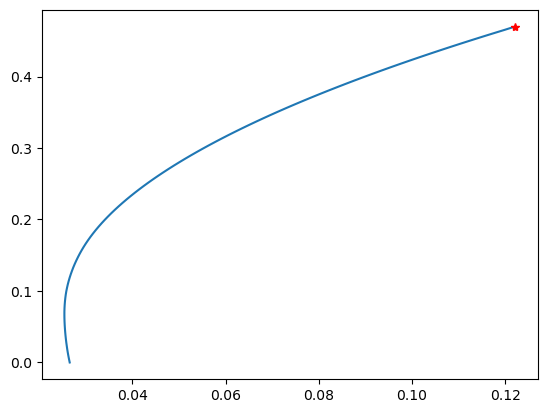

In [351]:
def draw(target):
    mu = stocks_mean
    cov = covariance
    n = len(mu)
    target_return = target  
    def portfolio_variance(weights):
        return np.dot(weights.T, np.dot(cov, weights))
    def portfolio_return(weights):
        return np.dot(weights.T, mu)
    def portfolio_constraint(weights):
        return np.sum(weights) - 1
    def target_return_constraint(weights):
        return portfolio_return(weights) - target_return

    x0 = np.array([1.0/n]*n)

    bounds = tuple((0,1) for i in range(n))

    result = minimize(portfolio_variance, x0, method='SLSQP', constraints=[{'type': 'eq', 'fun': portfolio_constraint},
                                                                        {'type': 'eq', 'fun': target_return_constraint}], bounds=bounds)

    weights = result.x

    port_return = portfolio_return(weights)
    port_var = portfolio_variance(weights)

    return port_var

var = []
for target in np.linspace(0,0.47,100):
    var.append(draw(target))
plt.plot(var, np.linspace(0,0.47,100))
plt.plot(port_var, port_return, 'r*')